# config.ipynb

In [52]:
!git config --global credential.helper store

In [53]:
# login to huggingface hub
from huggingface_hub import notebook_login
notebook_login()

In [13]:
!pip install uv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 72.3 MB/s eta 0:00:00


In [14]:
!uv pip install --system -q bitsandbytes peft accelerate lightning torch torchvision wandb transformers matplotlib

In [ ]:
import wandb

wandb.login(key="67995956199b3ccd2d5a0a6b55f2803b94210a9f")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: choijinho817 (paligemma-finetuning). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [54]:
%%capture
%%bash
TOKENIZERS_PARALLELISM=true

In [55]:
%%capture
%%bash
#!/bin/bash
DATA_DIR="data";

ZIPFILE_NAME="mathwriting-excerpt.tgz";

ZIPFILE_PATH="$DATA_DIR/$ZIPFILE_NAME";



UNZIPDIR_NAME="mathwriting-2024-excerpt";

UNZIPDIR_PATH="$DATA_DIR/$UNZIPDIR_NAME"



# make data directory if not exists

mkdir -p "$DATA_DIR"



# install math-writing dataset

if [ -e $ZIPFILE_PATH ]; then

	echo "$ZIPFILE_PATH - Already exists...";

else

	echo "$ZIPFILE_PATH - Doesn't exists. Starting download...";

	wget -O $ZIPFILE_PATH https://storage.googleapis.com/mathwriting_data/mathwriting-2024-excerpt.tgz;

fi



# check if unzip directory exists

if [ -d "$UNZIPDIR_PATH" ]; then

	echo "$UNZIPDIR_PATH - Already exists...";

else

	echo "$UNZIPDIR_PATH - Doesnt exists. Starting untar...";

	tar -xvzf "$ZIPFILE_PATH" -C "$DATA_DIR";

fi


In [56]:
# Configuration

import torch

from datetime import datetime

import logging

from pathlib import Path

import os



# Configure Directory

project_dir = Path(os.getcwd()).parent / "content"

data_dir = project_dir / "data"

model_dir = project_dir / "models"

log_dir = project_dir / "logs"



data_dir.mkdir(parents=True, exist_ok=True)

model_dir.mkdir(parents=True, exist_ok=True)

log_dir.mkdir(parents=True, exist_ok=True)

print(f'project_dir: {project_dir}')

print(f'data_dir: {data_dir}')

print(f'model_dir: {model_dir}')

print(f'log_dir: {log_dir}')



# Configure logger

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

log_file = log_dir / f'log_{timestamp}.log'



logger = logging.getLogger('Handwriting2LaTeX')

logger.setLevel(logging.INFO)



file_handler = logging.FileHandler(log_file)

file_handler.setLevel(logging.INFO)



formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

file_handler.setFormatter(formatter)



logger.addHandler(file_handler)

# logger.addHandler(logging.StreamHandler())



# log the directory information

logger.info(f'PROJECT_DIR: {project_dir}')

logger.info(f'MODEL_DIR: {model_dir}')

logger.info(f'LOG_DIR: {log_dir}')



# Define Parameter for InkML parsing

TIME_SAMPLING_DELTA = 20

SEQ_MAX = 500

SEQ_MIN = -500

PADDING = 4



logger.info(f'TIME_SAMPLING_DELTA: {TIME_SAMPLING_DELTA}')

logger.info(f'SEQ_MAX: {SEQ_MAX}')

logger.info(f'SEQ_MIN: {SEQ_MIN}')

logger.info(f'PADDING: {PADDING}')



# Define Huggingface configuration

REPO_ID = "google/paligemma-3b-pt-224"

LOAD_FINETUNED_MODEL = False

FINETUNED_MODEL_ID = "ball1433/Handwriting2LaTeX"

# Define Training Parameter

MAX_LENGTH = 512

MAX_GENERATION_LENGTH = 128

BATCH_SIZE=3

EPOCHS = 200

IMG_SIZE=224

INIT_LR=1e-4

GRAD_CLIP=1.0

SEED=1234

WARMUP_STEPS=20

NUM_WORKERS=3

LORA_R=12

SHRINK_DATASET=True # if True, shrink train dataset to 3,000 entries / validation dataset to 1,000 entries


logger.info(f'EPOCHS: {EPOCHS}')

logger.info(f'BATCH_SIZE: {BATCH_SIZE}')

INFO:Handwriting2LaTeX:PROJECT_DIR: /content
INFO:Handwriting2LaTeX:MODEL_DIR: /content/models
INFO:Handwriting2LaTeX:LOG_DIR: /content/logs
INFO:Handwriting2LaTeX:TIME_SAMPLING_DELTA: 20
INFO:Handwriting2LaTeX:SEQ_MAX: 500
INFO:Handwriting2LaTeX:SEQ_MIN: -500
INFO:Handwriting2LaTeX:PADDING: 4
INFO:Handwriting2LaTeX:EPOCHS: 200
INFO:Handwriting2LaTeX:BATCH_SIZE: 3


project_dir: /content
data_dir: /content/data
model_dir: /content/models
log_dir: /content/logs


# InkML-parser.ipynb

In [57]:
from dataclasses import dataclass

import numpy as np

from xml.etree import ElementTree

import matplotlib.pyplot as plt

import matplotlib.patches as mpl_patches

from PIL import Image

import io

from pprint import pprint



# Define Ink class

@dataclass

class Ink:

    """Represents a single ink, as read from an InkML file."""

    # Every stroke in the ink.

    # Each stroke array has shape (3, number of points), where the first

    # dimensions are (x, y, timestamp), in that order.



    strokes: list[np.ndarray]

    # Metadata present in the InkML.

    annotations: dict[str, str]



    min_x: int

    min_y: int

    max_x: int

    max_y: int

    min_t: int

    max_t: int



    max_delta_x: int

    max_delta_y: int





# Define function that reads inkml file, and outputs Ink object

def read_inkml_file(filename: str) -> Ink:

    """Simple reader for MathWriting's InkML files."""

    with open(filename, "r") as f:

        root = ElementTree.fromstring(f.read())



        strokes = []

        annotations = {}



        max_x, max_y, max_t, min_x, min_y, min_t = None, None, None, None, None, None



        max_delta_x, max_delta_y = 0, 0



        for element in root:

            tag_name = element.tag.removeprefix('{http://www.w3.org/2003/InkML}')

            if tag_name == 'annotation':

                annotations[element.attrib.get('type')] = element.text



            elif tag_name == 'trace':

                points = element.text.split(',')

                stroke_x, stroke_y, stroke_t = [], [], []



                prev_x, prev_y = None, None

                for point in points:

                    x, y, t = [float(p) for p in point.split(' ')]

                    stroke_x.append(x)

                    stroke_y.append(y)

                    stroke_t.append(t)



                    if prev_x == None:

                        prev_x = x

                        prev_y = y



                    if max_x == None:

                        max_x = x

                        min_x = x

                        max_y = y

                        min_y = y

                        max_t = t

                        min_t = t

                    if x > max_x:

                        max_x = x

                    if x < min_x:

                        min_x = x

                    if y > max_y:

                        max_y = y

                    if y < min_y:

                        min_y = y

                    if t > max_t:

                        max_t = t

                    if t < min_t:

                        min_t = t

                    if abs(x - prev_x) > max_delta_x:

                        max_delta_x = abs(x - prev_x)

                    if abs(y - prev_y) > max_delta_y:

                        max_delta_y = abs(y - prev_y)



                    prev_x = x

                    prev_y = y

                strokes.append(np.array((stroke_x, stroke_y, stroke_t)))



    return Ink(strokes=strokes,

             annotations=annotations,

             max_x=max_x,

             min_x=min_x,

             max_y=max_y,

             min_y=min_y,

             max_t=max_t,

             min_t=min_t,

             max_delta_x=max_delta_x,

             max_delta_y=max_delta_y)



# display inkml file into image

def display_ink(

    ink: Ink,

    *,

    figsize: tuple[int, int]=(15, 10),

    linewidth: int=2,

    color=None):

  """Simple display for a single ink."""

  plt.figure(figsize=figsize)

  for stroke in ink.strokes:

    plt.plot(stroke[0], stroke[1], linewidth=linewidth, color=color)

    plt.title(

        f"{ink.annotations.get('sampleId', '')} -- "

        f"{ink.annotations.get('splitTagOriginal', '')} -- "

        f"{ink.annotations.get('normalizedLabel', ink.annotations['label'])}"

    )

  plt.gca().invert_yaxis()

  plt.gca().axis('equal')



def get_ink_sequence_token(ink: Ink, timedelta_: int):

    """

    Apply

    1. Time sampling

    2. Scale normalization

    3. Coordinate representation

    """



    # Time sampling

    time_sampled_strokes = []



    # time delta between two adjacent points should be at least timedelta_

    for stroke in ink.strokes:

        stroke_x, stroke_y, stroke_t = stroke[0], stroke[1], stroke[2]



        prev_t = stroke_t[0] - (float(timedelta_) * 2)

        sampled_stroke_x, sampled_stroke_y= [], []



        for x, y, t in zip(stroke_x, stroke_y, stroke_t):





            if t - prev_t >= timedelta_:

                prev_t = t

                # add this point to strokes

                sampled_stroke_x.append(x)

                sampled_stroke_y.append(y)



        time_sampled_strokes.append(np.array((sampled_stroke_x, sampled_stroke_y)))



    # Scale normalization

    scale_normalized_strokes = []



    # print(f'max_x: {max_x}, min_x: {min_x}, max_y: {max_y}, min_y: {min_y}')



    # for every point's x value, (x - min_x) * (IMG_SIZE - 2 * PADDING) / (max_x - min_x) + PADDING

    # for every point's y value, (y - min_y) * IMG_SIZE / (max_y - min_y)

    for stroke in time_sampled_strokes:

        stroke_x, stroke_y = stroke[0], stroke[1]



        normalized_stroke_x, normalized_stroke_y = [], []

        for x, y in zip(stroke_x, stroke_y):

            normalized_stroke_x.append(((x - ink.min_x) * (IMG_SIZE - 2 * PADDING) / (ink.max_x - ink.min_x)) + PADDING)

            normalized_stroke_y.append(((y - ink.min_y) * (IMG_SIZE - 2 * PADDING) / (ink.max_y - ink.min_y)) + PADDING)



        scale_normalized_strokes.append(np.array((normalized_stroke_x, normalized_stroke_y)))



    # pprint(scale_normalized_strokes)



    # Discretization

    # Converting all float coordinates into int

    discretized_strokes = []



    for stroke in scale_normalized_strokes:

        stroke_x, stroke_y = stroke[0], stroke[1]



        discretized_stroke_x, discretized_stroke_y = [], []



        for x, y in zip(stroke_x, stroke_y):

            discretized_stroke_x.append(round(x))

            discretized_stroke_y.append(round(y))



        discretized_strokes.append(np.array((discretized_stroke_x, discretized_stroke_y)))



    # pprint(discretized_strokes)



    # Coordinate representation

    relative_position_strokes = []



    for stroke in discretized_strokes:

        stroke_x, stroke_y = stroke[0], stroke[1]



        relative_stroke_x, relative_stroke_y = [], []



        prev_x, prev_y = None, None



        for x, y in zip(stroke_x, stroke_y):

            if prev_x == None and prev_y == None:

                relative_stroke_x.append(x)

                relative_stroke_y.append(y)

                prev_x = x

                prev_y = y

            else:

                relative_stroke_x.append(x - prev_x)

                relative_stroke_y.append(y - prev_y)



        relative_position_strokes.append(np.array((relative_stroke_x, relative_stroke_y)))

    # pprint(relative_position_strokes)



    # return string of sequences of points

    # new stroke starts with seperator <stroke>

    result = ""

    for stroke in relative_position_strokes:

        stroke_x, stroke_y = stroke[0], stroke[1]

        result += "<stroke> "



        for x, y in zip(stroke_x, stroke_y):

            if x > SEQ_MAX:

                x = SEQ_MAX

            if x < SEQ_MIN:

                x = SEQ_MIN



            if y > SEQ_MAX:

                y = SEQ_MAX

            if y < SEQ_MIN:

                y = SEQ_MIN



            result += f'{x} {y} '



    # print(f'token length: {len(result.split())}')

    return result





def get_ink_image(ink: Ink,

                  figsize: int = 800,

                  linewidth: int=1):

    """

    returns a ink image of shape (figsize, figsize, 3)

    containing time, delta_x, delta_y information in color channel

    """



    dpi = 100

    width = figsize * 2

    height = figsize // 2



    fig, ax = plt.subplots(figsize=(width // dpi, height // dpi), dpi=dpi)

    ax.axis('off')



    for stroke in ink.strokes:

        stroke_x, stroke_y, stroke_t = stroke[0], stroke[1], stroke[2]

        colors = []



        prev_x, prev_y, prev_t = None, None, None



        for x, y, t in zip(stroke_x, stroke_y, stroke_t):

            if prev_x == None:

                prev_x = x

                prev_y = y

                prev_t = t



            # store img_drawing[(x, y)] = (r, g, b)

            # r, g, b range 0 - 1

            r = (t - ink.min_t) / (ink.max_t - ink.min_t)

            g = abs(x - prev_x) / ink.max_delta_x

            b = abs(y - prev_y) / ink.max_delta_y



            colors.append((r, g, b))



            prev_x = x

            prev_y = y

            prev_t = t

        for i in range(len(stroke_x)):

            ax.plot(stroke_x[i:i+2], stroke_y[i:i+2], linewidth=linewidth, color=colors[i])

    ax.invert_yaxis()

    ax.axis('equal')



    plt.close()

    fig.canvas.draw()

    plt.tight_layout()

    # plt.show()



    # width, height = fig.canvas.get_width_height()





    img_array = np.array(fig.canvas.buffer_rgba())

    img_array = img_array[:, :, :3]

    height, width, _ = img_array.shape



    left_img_array = img_array[:, :(width//2), :]

    right_img_array = img_array[:, (width//2):, :]

    # print(f'left_img_array shape: {left_img_array.shape}')

    # print(f'right_img_array shape: {right_img_array.shape}')



    img_array = np.concatenate((left_img_array, right_img_array), axis=0)



    # print(f'img_array shape: {img_array.shape}')



    return img_array



# Tokenizer.ipynb

In [67]:
from transformers import AutoTokenizer

custom_tokenizer = AutoTokenizer.from_pretrained(REPO_ID)

new_tokens = ["<eos>", "<stroke>", "!", "&", "(", ")", "*", "+", ",", "-", ".", "/", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", ":", ";", "¡", "=", "¿", "?", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U","V", "W", "X", "Y", "Z", "[", r"\#", r"\%", r"\&", r"\Delta", r"\Gamma", r"\Lambda", r"\Leftrightarrow", r"\Omega", r"\Phi", r"\Pi", r"\Psi", r"\Rightarrow", r"\Sigma", r"\Theta", r"\Upsilon", r"\Vdash", r"\Xi", r"\ ", r"\aleph", r"\alpha", r"\angle", r"\approx", r"\backslash", r"\beginmatrix", r"\beta", r"\bigcap", r"\bigcirc", r"\bigcup", r"\bigoplus", r"\bigvee", r"\bigwedge", r"\bullet", r"\cap", r"\cdot", r"\chi", r"\circ", r"\cong", r"\cup", r"\dagger", r"\delta", r"\div", r"\dot", r"\emptyset", r"\endmatrix", r"\epsilon", r"\equiv", r"\eta", r"\exists", r"\forall", r"\frac", r"\gamma", r"\ge", r"\gg", r"\hat", r"\hbar", r"\hookrightarrow", r"\iff", r"\iint", r"\in", r"\infty", r"\int", r"\iota", r"\kappa", r"\lambda", r"\langle", r"\lceil", r"\le", r"\leftarrow", r"\leftrightarrow", r"\lfloor", r"\ll", r"\longrightarrow", r"\mapsto", r"\mathbb", r"\models", r"\mp", r"\mu", r"\nabla", r"\ne", r"\neg", r"\ni", r"\not", r"\notin", r"\nu", r"\odot", r"\oint", r"\omega", r"\ominus", r"\oplus", r"\otimes", r"\overline", r"\partial", r"\perp", r"\phi", r"\pi", r"\pm", r"\prime", r"\prod", r"\propto", r"\psi", r"\rangle", r"\rceil", r"\rfloor", r"\rho", r"\rightarrow", r"\rightleftharpoons", r"\sigma", r"\sim", r"\simeq", r"\sqrt", r"\sqsubseteq", r"\subset", r"\subseteq", r"\subsetneq", r"\sum", r"\supset", r"\supseteq", r"\tau", r"\theta", r"\tilde", r"\times", r"\top", r"\triangle", r"\triangleleft", r"\triangleq", r"\underline", r"\upsilon", r"\varphi", r"\varpi", r"\varsigma", r"\vartheta", r"\vdash", r"\vdots", r"\vec", r"\vee", r"\wedge", r"\xi", r"\zeta", r"\{", r"\—", r"\}", "]", "ˆ", " ", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "{", "|", "}", "\\" ]

new_tokens = set(new_tokens) - set(custom_tokenizer.vocab.keys())

custom_tokenizer.add_tokens(list(new_tokens))


138

In [68]:
# TEST PURPOSE

for token in list(new_tokens)[:10]:

    token_id = custom_tokenizer.convert_tokens_to_ids(token)

    print(f"Token: {token}, ID: {token_id}")

Token: \Upsilon, ID: 257153
Token: \vec, ID: 257154
Token: \models, ID: 257155
Token: \iota, ID: 257156
Token: \bigcup, ID: 257157
Token: \notin, ID: 257158
Token: \rightarrow, ID: 257159
Token: \sqsubseteq, ID: 257160
Token: \iff, ID: 257161
Token: \prod, ID: 257162


# Train.ipynb

## Define a collate function

In [79]:
from transformers import AutoProcessor

import matplotlib.pyplot as plt


processor = AutoProcessor.from_pretrained(REPO_ID)

# change the default tokenizer into custom tokenizer

processor.tokenizer = custom_tokenizer



def train_collate_fn(samples):

  images = [sample["image"] for sample in samples]


  text_sequences = ["<image>" + sample["text"] for sample in samples]

  labels = [sample["label"]+"<eos>" for sample in samples]



  inputs = processor(text=text_sequences, images=images, suffix=labels, return_tensors="pt",

                     padding=True, truncation=True, max_length=MAX_LENGTH)



  input_ids = inputs["input_ids"]

  token_type_ids = inputs["token_type_ids"]

  attention_mask = inputs["attention_mask"]

  pixel_values = inputs["pixel_values"]

  labels = inputs["labels"]

  return input_ids, token_type_ids, attention_mask, pixel_values, labels



def test_collate_fn(samples):

    images = [sample["image"] for sample in samples]

    text_sequences = ["<image>" + sample["text"] for sample in samples]

    labels = [sample["label"]+"<eos>" for sample in samples]



    inputs = processor(text=text_sequences, images=images, return_tensors="pt",

                         padding=True, truncation=True, max_length=MAX_LENGTH)

    input_ids = inputs["input_ids"]

    attention_mask = inputs["attention_mask"]

    pixel_values = inputs["pixel_values"]

    return input_ids, attention_mask, pixel_values, labels

# Datasets and DataLoader

In [80]:
import torch

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

import os

import numpy as np

import time

import matplotlib.pyplot as plt

class MathWritingDataset(Dataset):

    def __init__(self, dataset_dir, data_types=["train", "symbols", "synthetic"], transform=None):

        self.dataset_dir = dataset_dir

        self.types = data_types

        self.filenames = []

        self.transform = transform

        for type_ in self.types:

            filename = [f'{type_}/{f.name}' for f in (self.dataset_dir / type_).glob("*.inkml")]

            self.filenames.extend(filename)

    def __len__(self):

        return len(self.filenames)



    def __getitem__(self, idx):

        # start = time.time()

        assert type(idx) == int

        target_file_path = self.dataset_dir / self.filenames[idx]



        # read inkml file

        ink = read_inkml_file(target_file_path)



        # generate ink sequence

        text_sequence = get_ink_sequence_token(ink, TIME_SAMPLING_DELTA)



        image = get_ink_image(ink, IMG_SIZE)

        if "normalizedLabel" in ink.annotations:

          label = ink.annotations['normalizedLabel']

        else:

          label = ink.annotations['label']



        sample = {'image': image, 'text': text_sequence, 'label': label}



        if self.transform:

            sample = self.transform(sample)



        # print(f'time taken to load one data: {time.time() - start}s')



        return sample



# FIXME

# change "mathwriting-2024-excerpt" into "mathwriting-2024" for real training

train_dataset = MathWritingDataset(data_dir / "mathwriting-2024-excerpt", data_types=["train", "symbols", "synthetic"])

test_dataset = MathWritingDataset(data_dir / "mathwriting-2024-excerpt", data_types=["test"])

if SHRINK_DATASET:
  train_dataset = torch.utils.data.Subset(train_dataset, range(3_000))
  test_dataset = torch.utils.data.Subset(test_dataset, range(1_000))

# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_collate_fn)

# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_collate_fn)


input_ids(encoding inkml sequence): tensor([     2, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
    

input_ids(encoding inkml sequence): tensor([     2, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
        257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
    

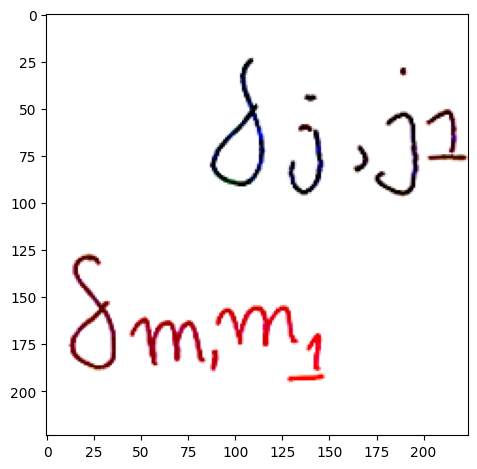

In [84]:
# TEST PURPOSE
# see the dataset, plot the images
import matplotlib.pyplot as plt

tmp_train_dataset = torch.utils.data.Subset(train_dataset, range(10))
tmp_train_dataloader = DataLoader(tmp_train_dataset, batch_size=2, shuffle=False, collate_fn=train_collate_fn)


it = iter(tmp_train_dataloader)
input_ids, token_type_ids, attention_mask, pixel_values, labels = next(it)


# show images by plotting pixel_values
plt.imshow(pixel_values[0].permute(1, 2, 0))

# show the inkml sequence
print(f"input_ids(encoding inkml sequence): {input_ids[0]}")
print(f"shape of input_ids: {input_ids[0].shape}")

# decode input_ids
print(f"decoded input_ids: {custom_tokenizer.batch_decode(input_ids)[0]}")

tmp_test_dataset = torch.utils.data.Subset(test_dataset, range(10))
tmp_test_dataloader = DataLoader(tmp_test_dataset, batch_size=2, shuffle=False, collate_fn=test_collate_fn)

it = iter(tmp_test_dataloader)
input_ids, attention_mask, pixel_values, labels = next(it)

# show images by plotting pixel_values
plt.imshow(pixel_values[0].permute(1, 2, 0))

# show the inkml sequence
print(f"input_ids(encoding inkml sequence): {input_ids[0]}")
print(f"shape of input_ids: {input_ids[0].shape}")

# decode input_ids
print(f"decoded input_ids: {custom_tokenizer.batch_decode(input_ids)[0]}")

## Pytorch LightningModule

In [ ]:
import lightning as L
import re
from nltk import edit_distance
import numpy as np

class PaliGemmaModel(L.LightningModule):

    def __init__(self, config, processor, model):

        super().__init__()

        self.lr = INIT_LR
        self.config = config
        self.processor = processor
        self.model = model
        self.batch_size=config.get("batch_size")
        self.train_losses = []
        self.val_losses = []
        self.val_scores = []


    def training_step(self, batch, batch_idx):
        input_ids, token_type_ids, attention_mask, pixel_values, labels = batch

        # outputs: transformers.models.paligemma.modeling_paligemma.PaliGemmaCausalLMOutputWithPast

        # outputs.loss is provided if labels is given.
        outputs = self.model(input_ids=input_ids,

                             attention_mask=attention_mask,

                             token_type_ids=token_type_ids,

                             pixel_values=pixel_values,

                             labels=labels)

        train_loss = outputs.loss

        self.train_losses.append(train_loss.item())

        self.log("train/loss", train_loss)

        return train_loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, labels = batch

        # look at https://github.com/huggingface/transformers/blob/v4.47.1/src/transformers/generation/utils.py#L1904 for detailed documentation of model.generate() method
        # to get the logits of the generated text, we should set return_dict_in_generate=True
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, max_new_tokens=MAX_GENERATION_LENGTH)

        # add 1 to input_ids size to skip the bos token
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1)+1:], skip_special_tokes=True)

        scores = []
        for pred, label in zip(predictions, labels):

            self.val_scores.append(edit_distance(pred, label) / max(len(pred), len(label)))
            scores.append(edit_distance(pred, label) / max(len(pred), len(label)))

            if self.config.get("verbose", False) and batch_idx % 100 == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {label}")
                print(f" Normed ED: {self.val_scores[-1]}")

        self.log("val/edit_distance", np.mean(scores))

        return scores

    def on_train_epoch_end(self):
        # print the average of training loss
        print(f'Average Training Loss in EPOCH #{self.current_epoch}: {np.mean(self.train_losses)}')
        # reset the list
        self.train_losses = []

    def on_validation_epoch_end(self):
        # print the average of edit distance score
        print(f'Average Validation Score in EPOCH #{self.current_epoch}: {np.mean(self.val_scores)}')
        self.val_scores = []

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=train_collate_fn, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=test_collate_fn, num_workers=NUM_WORKERS)


## Q-LoRA configuration

In [ ]:
from transformers import BitsAndBytesConfig

from peft import get_peft_model, LoraConfig



bnb_config = BitsAndBytesConfig(

    load_in_4bit=True,

    bnb_4bit_quant_type="nf4",

    bnb_4bit_compute_dtype=torch.bfloat16

)



lora_config = LoraConfig(

    r=LORA_R,

    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],

    task_type="CAUSAL_LM",

)


## Define the Model

In [ ]:
from transformers import PaliGemmaForConditionalGeneration

model = PaliGemmaForConditionalGeneration.from_pretrained(REPO_ID, quantization_config=bnb_config)
# For CPU, no quantization
# model = PaliGemmaForConditionalGeneration.from_pretrained(REPO_ID)

model.resize_token_embeddings(len(custom_tokenizer))

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


trainable params: 16,948,224 || all params: 2,940,570,352 || trainable%: 0.5764


In [ ]:
config = {"max_epochs": EPOCHS,
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": GRAD_CLIP,
          "accumulate_grad_batches": 2,
          "lr": INIT_LR,
          "batch_size": BATCH_SIZE,
          "seed":SEED,
          "num_nodes": 1,
          "warmup_steps": WARMUP_STEPS,
          "result_path": log_dir,
          "verbose": True,
}



model_module = PaliGemmaModel(config, processor, model)

#### Define Wandb Logger

In [ ]:
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="Handwriting2Latex")

#### Define Callbacks

In [ ]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from huggingface_hub import HfApi


api = HfApi()

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Train Epoch end: Pushing model to the hub, epoch {trainer.current_epoch}")

        pl_module.model.push_to_hub(FINETUNED_MODEL_ID,
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")



    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")

        pl_module.processor.push_to_hub(FINETUNED_MODEL_ID,
                                    commit_message=f"Training done")

        pl_module.model.push_to_hub(FINETUNED_MODEL_ID,
                                    commit_message=f"Training done")


early_stop_callback = EarlyStopping(monitor="val/edit_distance", patience=10, verbose=False, mode="min")

## Train

In [ ]:
from lightning.pytorch.tuner import Tuner

trainer = L.Trainer(
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=1.0,
        val_check_interval=0.5,
        num_sanity_val_steps=2,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback]
)

# tuner = Tuner(trainer)
# tuner.scale_batch_size(model_module, mode="power")

trainer.fit(model_module)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | PeftModelForCausalLM | 1.7 B  | train
-------------------------------------------------------
16.9 M    Trainable params
1.7 B     Non-trainable params
1.7 B     Total params
6,971.805 Total estimated model params size (MB)
2072      Modules in train mode
593       Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | PeftModelForCausalLM | 1.7 B  | train
-------------------------------------------------------
16.9 M    Trainable params
1.7 B     Non-trainable params
1.7 B     Total params
6,971.805 Total estimated model params size (MB)
2072      Modules in train mode
593       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Prediction: 4<eos>
    Answer: \Delta w=\eta y(x_{n})x_{n}<eos>
 Normed ED: 0.84375
Prediction: <pad><pad>
    Answer: \vec{m}\in M<eos>
 Normed ED: 0.8823529411764706
Prediction: 1<eos>
    Answer: Q_{n-1}^{k}<eos>
 Normed ED: 0.625
Average Validation Score in EPOCH #0: 0.8018504901960783


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: A=n(x_{n}x_{n})<eos>
    Answer: \Delta w=\eta y(x_{n})x_{n}<eos>
 Normed ED: 0.5
Prediction: n>eM<eos><pad><pad><pad><pad><pad><pad><pad><pad>
    Answer: \vec{m}\in M<eos>
 Normed ED: 0.9387755102040817
Prediction: Q=a-1<eos><pad><pad><pad><pad><pad><pad><pad>
    Answer: Q_{n-1}^{k}<eos>
 Normed ED: 0.9111111111111111
Prediction: [0,5]<eos><pad><pad><pad><pad><pad>
    Answer: [0,0.5]<eos>
 Normed ED: 0.7714285714285715
Prediction: 1+3=4 mod (3)<eos><pad>
    Answer: 1+3=4mod13<eos>
 Normed ED: 0.391304347826087
Prediction: D.v=3y+2/z<eos>
    Answer: \nabla\cdot\vec{v}=3y+2yz<eos>
 Normed ED: 0.6
Prediction: (1/5) (1-5)<eos>
    Answer: (\begin{matrix}1\\ \frac{c}{\rho}\end{matrix}),(\begin{matrix}1\\ -\frac{c}{\rho}\end{matrix})<eos>
 Normed ED: 0.8787878787878788
Prediction: p(u)=d(u,u)<eos>
    Answer: \phi(u):=d(\tilde{u},u)<eos>
 Normed ED: 0.42857142857142855
Prediction: x=y+1-x^{2}<eos>
    Answer: \frac{x}{4}+\frac{1}{x^{2}}<eos>
 Normed ED: 0.59375
Prediction: 

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Average Validation Score in EPOCH #0: 0.673937522719254


Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: |w=n(x_{n})x_{n}<eos>
    Answer: \Delta w=\eta y(x_{n})x_{n}<eos>
 Normed ED: 0.40625
Prediction: =m^{2}E^{2}M<eos><pad><pad><pad>
    Answer: \vec{m}\in M<eos>
 Normed ED: 0.78125
Prediction: Q|r-1<eos><pad><pad><pad><pad><pad><pad><pad><pad>
    Answer: Q_{n-1}^{k}<eos>
 Normed ED: 0.92
Prediction: [0,0.5]<eos><pad><pad><pad>
    Answer: [0,0.5]<eos>
 Normed ED: 0.5555555555555556
Prediction: |+3=4mid|3<eos><pad><pad>
    Answer: 1+3=4mod13<eos>
 Normed ED: 0.52
Prediction: D.v=3y+2/2<eos>
    Answer: \nabla\cdot\vec{v}=3y+2yz<eos>
 Normed ED: 0.6333333333333333
Prediction: (1/g)^{1}-(1-g)^{1}<eos>
    Answer: (\begin{matrix}1\\ \frac{c}{\rho}\end{matrix}),(\begin{matrix}1\\ -\frac{c}{\rho}\end{matrix})<eos>
 Normed ED: 0.8484848484848485
Prediction: f(u):=d(u,u)<eos><pad><pad><pad>
    Answer: \phi(u):=d(\tilde{u},u)<eos>
 Normed ED: 0.78125
Prediction: x+1{1}{x^{2}}<eos><pad><pad><pad>
    Answer: \frac{x}{4}+\frac{1}{x^{2}}<eos>
 Normed ED: 0.8181818181818182
Predicti

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/67.9M [00:00<?, ?B/s]

Average Training Loss in EPOCH #0: 3.4973299958109854


Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: ∆w=n(x_{n})x_{n}<eos>
    Answer: \Delta w=\eta y(x_{n})x_{n}<eos>
 Normed ED: 0.40625
Prediction: \{n\}M<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad>
    Answer: \vec{m}\in M<eos>
 Normed ED: 0.9285714285714286
Prediction: Q|1-1<eos><pad><pad><pad><pad><pad><pad><pad><pad>
    Answer: Q_{n-1}^{k}<eos>
 Normed ED: 0.92
Prediction: [\begin{matrix}0&5\end{matrix}]<eos>
    Answer: [0,0.5]<eos>
 Normed ED: 0.75
Prediction: 1+3=4 mid|3<eos><pad><pad><pad><pad><pad>
    Answer: 1+3=4mod13<eos>
 Normed ED: 0.6829268292682927
Prediction: D.v=3y+2/2<eos><pad><pad><pad>
    Answer: \nabla\cdot\vec{v}=3y+2yz<eos>
 Normed ED: 0.9333333333333333
Prediction: (\begin{matrix}1\begin{matrix}1\end{matrix}\end{matrix})-(1-i\begin{matrix}5\end{matrix})<eos>
    Answer: (\begin{matrix}1\\ \frac{c}{\rho}\end{matrix}),(\begin{matrix}1\\ -\frac{c}{\rho}\end{matrix})<eos>
 Normed ED: 0.3838383838383838
Prediction: \{f(u):d(u,u)\}<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: ∆w=n(x_{n})_{x_{n}}<eos>
    Answer: \Delta w=\eta y(x_{n})x_{n}<eos>
 Normed ED: 0.5
Prediction: {m}^{2}E^{M}<eos><pad><pad><pad>
    Answer: \vec{m}\in M<eos>
 Normed ED: 0.78125
Prediction: Q^{-^{-^{-^{-^{-^{-^{-}}}}}<eos><pad><pad><pad>
    Answer: Q_{n-1}^{k}<eos>
 Normed ED: 0.7659574468085106
Prediction: [0,0.5]<eos><pad><pad><pad><pad><pad>
    Answer: [0,0.5]<eos>
 Normed ED: 0.6756756756756757
Prediction: |+3|=4 mid|3<eos><pad><pad><pad><pad>
    Answer: 1+3=4mod13<eos>
 Normed ED: 0.6756756756756757
Prediction: D=v^{2}=3y+2/z<eos>
    Answer: \nabla\cdot\vec{v}=3y+2yz<eos>
 Normed ED: 0.5333333333333333
Prediction: (\begin{matrix}1\end{matrix})-(1-p)^{(1-p)}<eos>
    Answer: (\begin{matrix}1\\ \frac{c}{\rho}\end{matrix}),(\begin{matrix}1\\ -\frac{c}{\rho}\end{matrix})<eos>
 Normed ED: 0.6060606060606061
Prediction: \{u\}\=d(a,u)<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
    Answer: \phi(u):=d(\tilde{u},u)<eos>
 Normed ED: 0.8904109589041096
Pred

adapter_model.safetensors:   0%|          | 0.00/67.9M [00:00<?, ?B/s]

Average Training Loss in EPOCH #1: 2.484870036840439


Validation: |          | 0/? [00:00<?, ?it/s]

Prediction:  ☐w=n(x_{n})_{x_{n}}<eos>
    Answer: \Delta w=\eta y(x_{n})x_{n}<eos>
 Normed ED: 0.5
Prediction: -m^{2}E<eos><pad><pad><pad><pad><pad><pad><pad>
    Answer: \vec{m}\in M<eos>
 Normed ED: 0.9361702127659575
Prediction: Q_{n-1}<eos><pad><pad><pad><pad><pad><pad><pad>
    Answer: Q_{n-1}^{k}<eos>
 Normed ED: 0.8085106382978723
Prediction: [\begin{matrix}0&0&5\end{matrix}]<eos>
    Answer: [0,0.5]<eos>
 Normed ED: 0.7368421052631579
Prediction: 1+3=4 mid|3<eos><pad><pad><pad><pad><pad><pad><pad>
    Answer: 1+3=4mod13<eos>
 Normed ED: 0.7450980392156863
Prediction: D.v=3y+2/2<eos><pad><pad><pad><pad><pad>
    Answer: \nabla\cdot\vec{v}=3y+2yz<eos>
 Normed ED: 0.925
Prediction: (1/c)^{1}(-c/p)<eos>
    Answer: (\begin{matrix}1\\ \frac{c}{\rho}\end{matrix}),(\begin{matrix}1\\ -\frac{c}{\rho}\end{matrix})<eos>
 Normed ED: 0.8585858585858586
Prediction:  phat=d(a,u)<eos><pad><pad><pad>
    Answer: \phi(u):=d(\tilde{u},u)<eos>
 Normed ED: 0.78125
Prediction: x+i^{x^{2}}<eos><pad><

Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: ∆w=n(x_{n})^{x_{n}}<eos>
    Answer: \Delta w=\eta y(x_{n})x_{n}<eos>
 Normed ED: 0.5
Prediction: m>e^{M}<eos><pad><pad><pad><pad><pad><pad><pad>
    Answer: \vec{m}\in M<eos>
 Normed ED: 0.8936170212765957
Prediction: Q^{-1}n-1<eos><pad><pad><pad><pad><pad><pad>
    Answer: Q_{n-1}^{k}<eos>
 Normed ED: 0.8181818181818182
Prediction: [\begin{matrix}0&5\end{matrix}]<eos>
    Answer: [0,0.5]<eos>
 Normed ED: 0.75
Prediction: |1+3|=4m_{ind}|3<eos><pad><pad>
    Answer: 1+3=4mod13<eos>
 Normed ED: 0.5806451612903226
Prediction: D.v=3y+2/z<eos><pad><pad><pad>
    Answer: \nabla\cdot\vec{v}=3y+2yz<eos>
 Normed ED: 0.9333333333333333
Prediction: (\begin{matrix}1\ stockfotografie{c}\end{matrix})(\begin{matrix}-1\end{matrix})<eos>
    Answer: (\begin{matrix}1\\ \frac{c}{\rho}\end{matrix}),(\begin{matrix}1\\ -\frac{c}{\rho}\end{matrix})<eos>
 Normed ED: 0.36363636363636365
Prediction: (u)=d(u,u)<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
    

adapter_model.safetensors:   0%|          | 0.00/67.9M [00:00<?, ?B/s]

Average Training Loss in EPOCH #2: 2.265222505003214


Validation: |          | 0/? [00:00<?, ?it/s]

Prediction: (x_{n})x_{n}<eos><pad>
    Answer: \Delta w=\eta y(x_{n})x_{n}<eos>
 Normed ED: 0.625
Prediction: -n^{2}E^{n}M<eos>
    Answer: \vec{m}\in M<eos>
 Normed ED: 0.5294117647058824
Prediction: Q|1-n-1<eos><pad><pad><pad>
    Answer: Q_{n-1}^{k}<eos>
 Normed ED: 0.7777777777777778


## Inference from test dataset

In [ ]:
input_ids, attention_mask, pixel_values, labels = next(iter(model_module.val_dataloader))

generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, max_new_tokens=MAX_GENERATION_LENGTH)

# add 1 to input_ids size to skip the bos token
predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1)+1:], skip_special_tokes=True)

for pred, label in zip(predictions, labels):
    print(f"Prediction: {pred}")

    print(f"    Answer: {label}")

    print(f" Normed ED: {edit_distance(pred, label) / max(len(pred), len(label))}")